In [162]:
%pip install openai -q -U

In [163]:
import os
import json
import shutil
import openai
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from warnings import filterwarnings
filterwarnings('ignore')

In [164]:
azure_client: openai.AzureOpenAI|None = None
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  azure_client = openai.AzureOpenAI(
      azure_endpoint=userdata.get('AZURE_OPENAI_ENDPOINT'),
      api_version=userdata.get('OPENAI_API_VERSION'),
      api_key=userdata.get('AZURE_OPENAI_API_KEY'),
  )

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str
7475327,2010-01-01 00:01:00,1556,2972,-77.0,"""Swipe Transaction""",59935,"""Beulah""","""ND""",58523.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",30,67,1989,7,"""Female""","""594 Mountain View Street""",46.8,-100.76,23679.0,48277.0,110153.0,740,4,"""Mastercard""","""Debit (Prepaid)""",5497590243197280,"""07/2022""",306,"""YES""",2,55.0,"""05/2008""",2008,"""No"""
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""","""No""",48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""","""No""",49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""","""No""",47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No"""


In [166]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
)
df.sample(5)

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str
10464732,2011-12-15 11:58:00,1908,5945,123.23,"""Swipe Transaction""",98374,"""Knoxville""","""TN""",37950.0,"""5411""",null,"""Grocery Stores, Supermarkets""","""No""",78,66,1942,2,"""Female""","""3601 Catherine Boulevard""",35.97,-83.94,24801.0,44469.0,12777.0,733,5,"""Visa""","""Credit""",4321453382786729,"""11/2024""",699,"""YES""",1,14900.0,"""12/2008""",2011,"""No""","""No""","""Knoxville""","""United States"""
21553574,2018-07-21 08:25:00,157,969,-76.0,"""Chip Transaction""",59935,"""Perris""","""CA""",92571.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",47,65,1972,10,"""Male""","""6232 Second Avenue""",33.83,-117.2,16109.0,32847.0,3230.0,785,3,"""Mastercard""","""Debit""",5481725798944325,"""05/2023""",964,"""YES""",1,14269.0,"""02/1999""",2011,"""No""","""No""","""Perris""","""United States"""
11198941,2012-05-31 15:35:00,1558,4747,32.32,"""Swipe Transaction""",18215,"""Brooklyn""","""NY""",11223.0,"""5719""",null,"""Miscellaneous Home Furnishing …","""No""",47,65,1973,2,"""Female""","""675 Little Creek Drive""",40.64,-73.94,25172.0,51330.0,106161.0,597,2,"""Visa""","""Debit""",4114768485287188,"""03/2023""",234,"""YES""",1,2566.0,"""09/2009""",2012,"""No""","""No""","""Brooklyn""","""United States"""
15290974,2014-11-23 04:38:00,1563,2054,0.71,"""Swipe Transaction""",14528,"""Los Angeles""","""CA""",90004.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",49,67,1970,8,"""Female""","""924 Spruce Street""",33.96,-118.27,11073.0,22583.0,62461.0,683,4,"""Visa""","""Debit""",4793063304202945,"""10/2023""",29,"""YES""",1,9290.0,"""03/2003""",2009,"""No""","""No""","""Los Angeles""","""United States"""
8408155,2010-08-20 08:50:00,668,4318,24.09,"""Swipe Transaction""",69956,"""Birmingham""","""AL""",35211.0,"""5310""",null,"""Discount Stores""","""No""",87,57,1932,10,"""Female""","""8569 Wessex Boulevard""",33.52,-86.79,13263.0,16342.0,1758.0,747,5,"""Mastercard""","""Credit""",5764603958082866,"""08/2021""",397,"""YES""",1,0.0,"""08/2010""",2010,"""No""","""No""","""Birmingham""","""United States"""


In [167]:
def floor_to_15min(dt_value: datetime) -> datetime|None:
    if dt_value is None:
        return None

    seconds_since_midnight = (dt_value - dt_value.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    interval_seconds = 15 * 60
    floored_seconds = (seconds_since_midnight // interval_seconds) * interval_seconds
    return dt_value.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(seconds=floored_seconds)

In [168]:
df = df.with_columns(
    pl.col("date").map_elements(floor_to_15min, return_dtype=pl.Datetime).alias("date_window")
)

In [169]:
def generate_columns_statistics(column_name: str) -> list:
    return [
        pl.col(column_name).mean().alias(f'mean_{column_name}'),
        pl.col(column_name).std().alias(f'std_{column_name}'),
        pl.col(column_name).skew().alias(f'skew_{column_name}'),
        pl.col(column_name).kurtosis().alias(f'kurtosis_{column_name}')
    ]

In [170]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

In [171]:
aggregate = [pl.col('amount').count().alias('transactions'), pl.col('target').sum().alias('frauds')]
for column in ['amount', 'current_age', 'per_capita_income', 'total_debt', 'credit_score', 'num_credit_cards', 'credit_limit']:
  aggregate.extend(generate_columns_statistics(column))

In [172]:
def list_structs_to_dict(list_of_structs, column_name):
  if list_of_structs is None:
      return None

  items = {}
  for item in list_of_structs:
    key = item[column_name]
    value = round(item['proportion'], 2)
    items[key] = value

  return items

def convert_categorical_to_percent(df: pl.DataFrame, column_name: str, group_by_column, drop_first=True) -> pl.DataFrame:
  list_structs_to_dict_column = lambda items: list_structs_to_dict(items, column_name)

  df_group = df.group_by(group_by_column).agg(pl.col(column_name).value_counts(normalize=True)).sort(group_by_column)

  df_fields = df_group.with_columns(
    pl.col(column_name).map_elements(
        list_structs_to_dict_column,
        return_dtype=pl.Object
  ).alias(column_name))

  fields = df_fields[column_name].to_list()
  data = pd.DataFrame(fields).fillna(0.0)
  data.columns = [f'{column_name}_{col.lower().replace(" ", "_")}' for col in data.columns]

  if drop_first:
    first_column = data.columns[0]
    data = data.drop(columns=[first_column])

  data = pl.from_pandas(data)
  data = data.with_columns(df_fields[group_by_column].alias(group_by_column))
  return data

In [173]:
df_model = df.group_by('date_window').agg(
    *aggregate
).sort('date_window')
df_model.head()

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726


In [174]:
for column in ['use_chip', 'gender', 'card_brand', 'card_type', 'has_chip', 'online_sales']:
  df_field = convert_categorical_to_percent(df, column, 'date_window')
  df_model = df_model.join(df_field, on='date_window', how='left')
df_model.head(10)

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit,use_chip_online_transaction,use_chip_swipe_transaction,use_chip_chip_transaction,gender_male,gender_female,card_brand_visa,card_brand_mastercard,card_brand_amex,card_brand_discover,card_type_debit,card_type_credit,card_type_debit_(prepaid),has_chip_yes,has_chip_no,online_sales_no,online_sales_yes
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432,0.17,0.83,0.0,0.67,0.33,0.17,0.83,0.0,0.0,0.33,0.17,0.5,1.0,0.0,0.83,0.17
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188,0.0,1.0,0.0,0.75,0.25,0.75,0.25,0.0,0.0,0.75,0.0,0.25,0.75,0.25,1.0,0.0
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159,0.2,0.8,0.0,0.5,0.5,0.2,0.8,0.0,0.0,0.6,0.4,0.0,1.0,0.0,0.8,0.2
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947,0.17,0.83,0.0,0.5,0.5,0.33,0.5,0.17,0.0,0.67,0.17,0.17,1.0,0.0,0.83,0.17
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726,0.5,0.5,0.0,0.33,0.67,0.17,0.83,0.0,0.0,0.67,0.33,0.0,1.0,0.0,0.5,0.5
2010-01-01 01:15:00,5,0,4.61,53.67871,-0.468739,-0.482601,43.6,7.402702,-0.754216,-0.771215,23935.4,3065.888664,0.013807,-0.528075,81437.8,28100.092281,1.039823,-0.491354,754.0,56.178288,1.098869,-0.206714,3.0,1.0,0.0,-1.75,14693.8,4012.619369,-0.062165,-1.724288,0.0,1.0,0.0,0.2,0.8,0.4,0.6,0.0,0.0,0.6,0.4,0.0,0.8,0.2,1.0,0.0
2010-01-01 01:30:00,4,0,17.535,17.586155,0.425266,-1.453984,67.0,20.314199,0.318187,-1.563732,25778.5,6119.646749,-0.905558,-0.842706,30717.5,34917.933869,0.121262,-1.83475,747.0,52.36411,0.19568,-1.262078,6.25,0.5,1.154701,-0.666667,24618.5,11453.384085,0.474271,-1.360883,0.0,1.0,0.0,0.0,1.0,0.0,0.75,0.25,0.0,0.75,0.25,0.0,1.0,0.0,1.0,0.0
2010-01-01 01:45:00,7,0,51.992857,34.98547,1.019653,-0.01202,56.428571,11.544943,-0.075079,-1.292404,25930.0,12385.902524,1.407045,0.814717,51734.285714,42299.149521,0.614604,-0.406747,726.285714,37.187427,-0.51775,-0.245965,4.285714,1.704336,-0.040073,-1.64781,21924.571429,25060.956213,1.683264,1.455575,0.43,0.57,0.0,0.43,0.57,0.29,0.57,0.14,0.0,0.71,0.14,0.14,1.0,0.0,0.57,0.43
2010-01-01 02:00:00,9,0,45.843333,68.940091,1.30041,0.377724,50.0,21.75431,1.6103

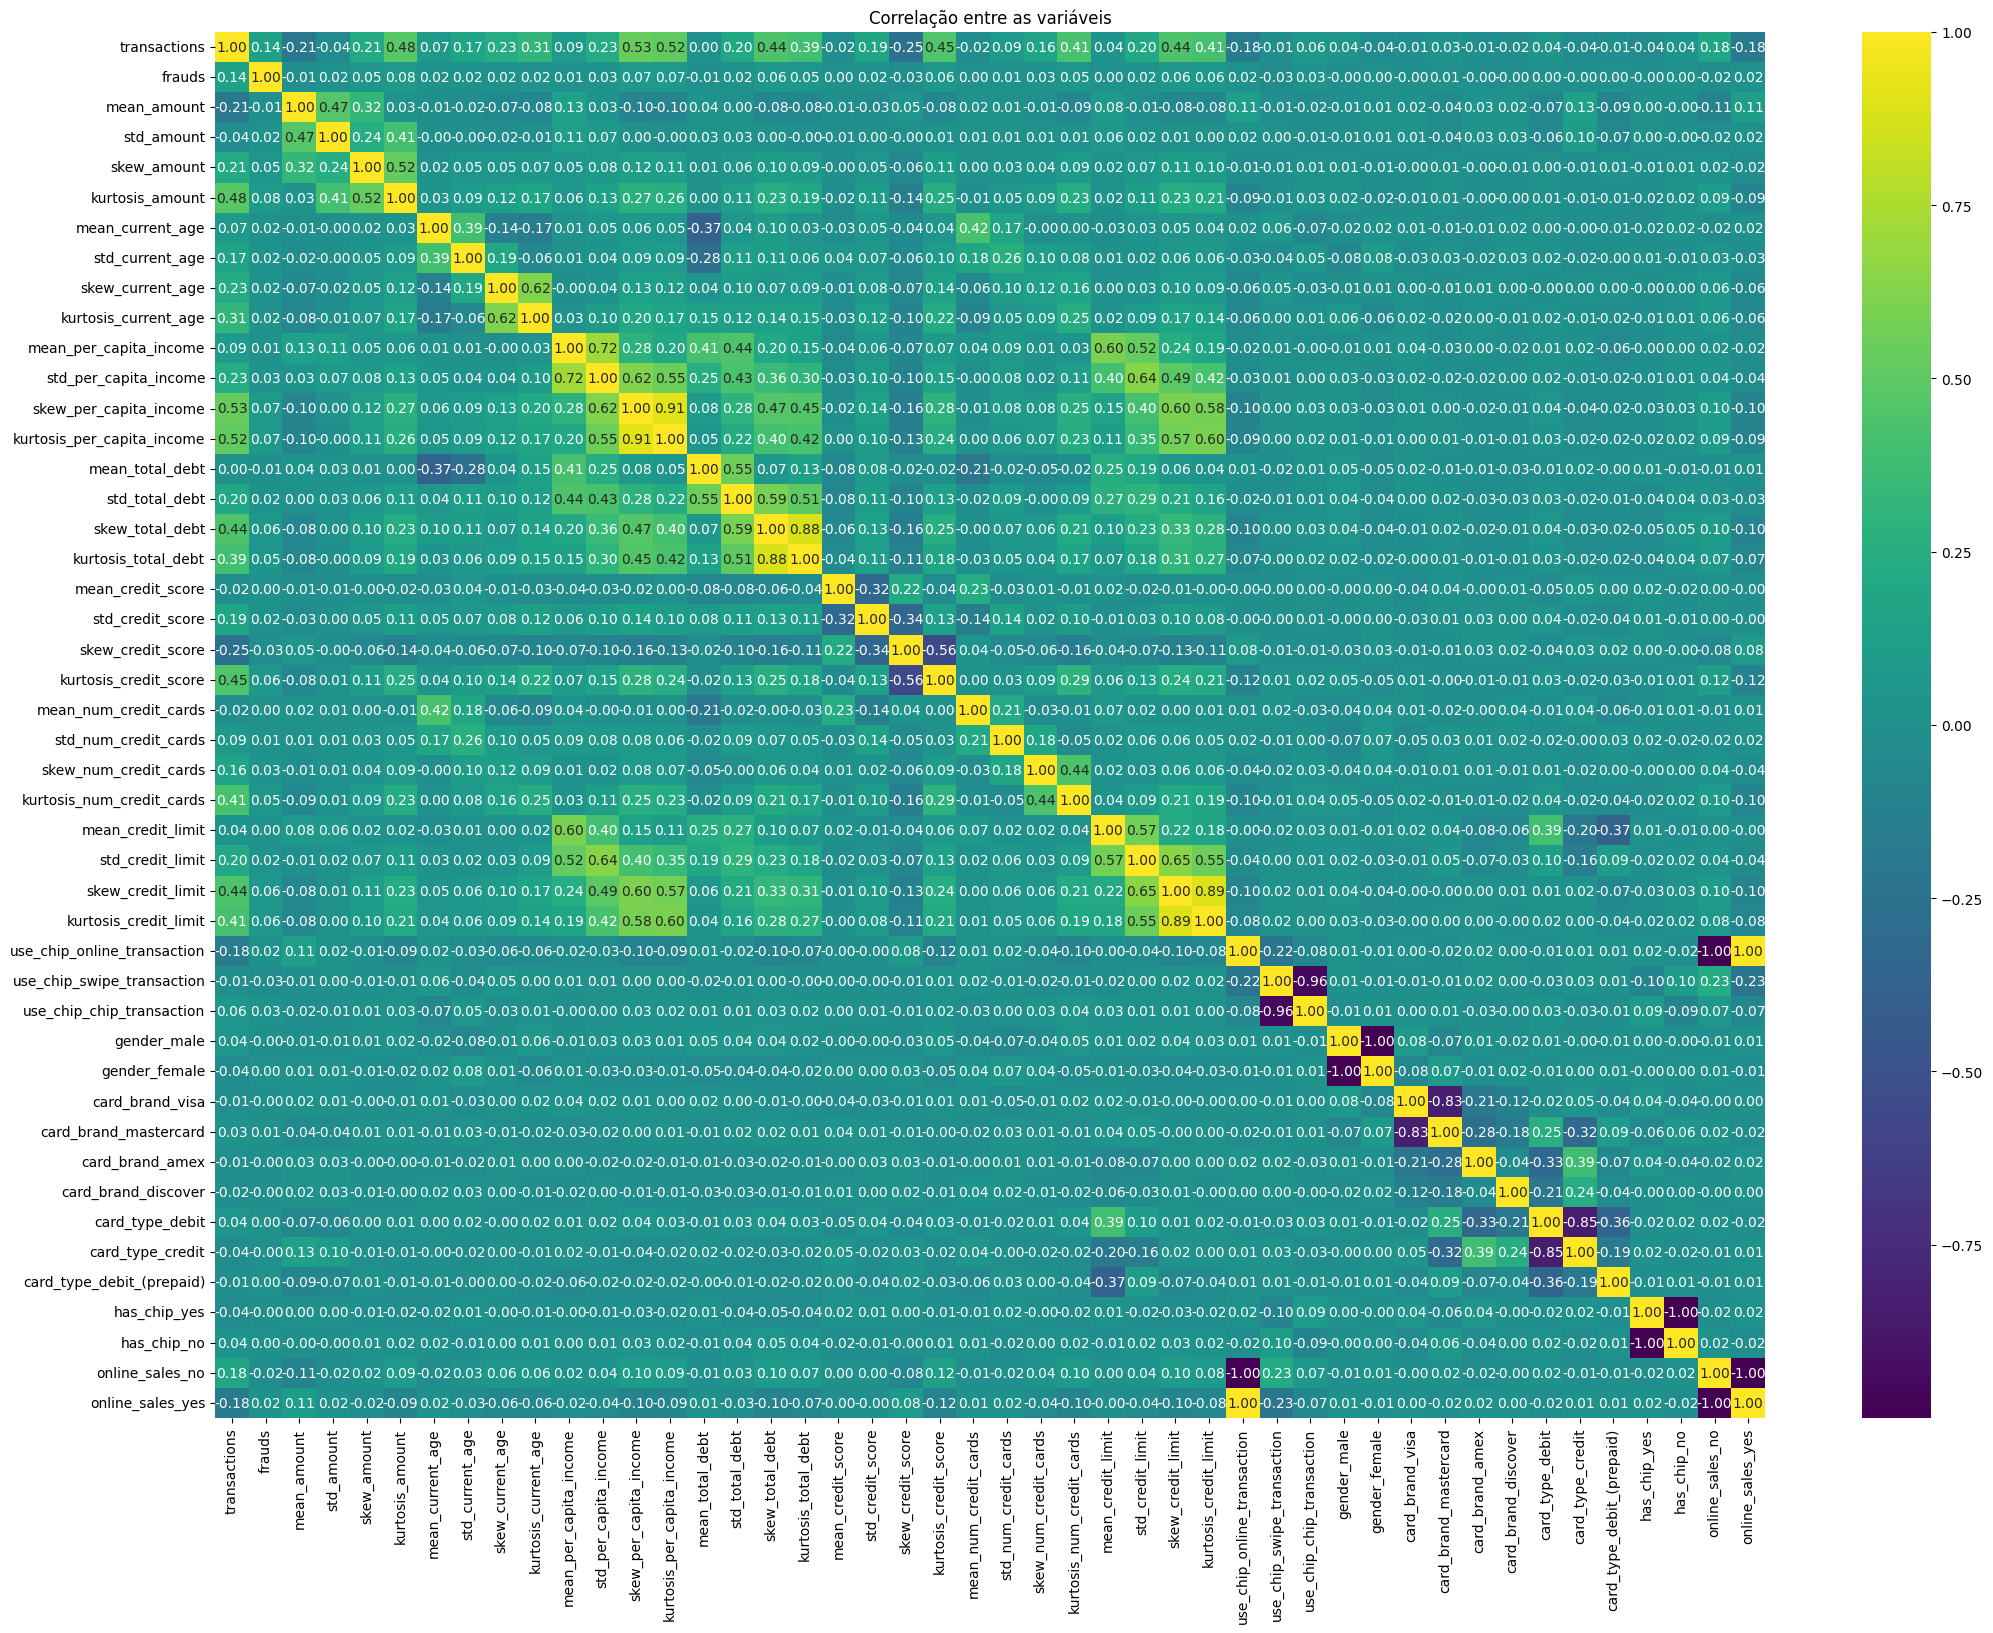

In [175]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()

plt.figure(figsize=(25,18))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

In [176]:
df_proportion = df['description'].value_counts(normalize=True).sort('proportion', descending=True)
df_proportion.head()

description,proportion
str,f64
"""Grocery Stores, Supermarkets""",0.119668
"""Miscellaneous Food Stores""",0.10986
"""Service Stations""",0.107137
"""Eating Places and Restaurants""",0.075133
"""Drug Stores and Pharmacies""",0.058037


In [177]:
df_proportion.shape

(108, 2)

In [178]:
df_proportion = df.group_by("description").agg([
    pl.len().alias("transaction_count"),
    pl.col("target").sum().alias("frauds"),
    pl.sum("amount").alias("total_amount"),
]).join(df_proportion, on='description', how='left')

In [179]:
df_proportion.filter(pl.col('proportion') >= 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.870067,7315


In [180]:
df_proportion.filter(pl.col('proportion') < 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.129933,6017


In [209]:
prompt = """
Agrupe as categorias de negócios e serviços que estão referenciadas em <dados></dados> em conjuntos homogêneos.
Cada grupo deve ser semanticamente coeso internamente e claramente distinto dos outros grupos (heterogêneo entre si).
Garanta que todas as categorias informadas em <dados></dados> estejam alocadas dentro de um grupo.
Para cada grupo identificado, forneça um nome descritivo e conciso que capture a essência dos itens pertencentes a ele.

---
FORMATO DE SAÍDA OBRIGATÓRIO:
Sua resposta deve ser uma lista de objetos JSON. Cada objeto representa um grupo e deve conter as seguintes chaves:
- `cluster`: Uma string, o nome descritivo do grupo.
- `items`: Uma lista de strings, contendo as categorias de negócios que pertencem a este grupo.

---
EXEMPLO ILUSTRATIVO DE SAÍDA ESPERADA (ESTRUTURA):
```json
[
  {
    "cluster": "Saúde e Bem-Estar",
    "items": ["Hospitais", "Clínicas Médicas", "Farmácias"]
  },
  {
    "cluster": "Varejo Alimentício",
    "items": ["Supermercados", "Padarias", "Açougues"]
  }
]
```

---
DADOS DE ENTRADA:

<dados>
[@dados]
</dados>


""".replace("@dados", str.join(';', df['description'].unique().to_list()))
prompt

'\nAgrupe as categorias de negócios e serviços que estão referenciadas em <dados></dados> em conjuntos homogêneos. \nCada grupo deve ser semanticamente coeso internamente e claramente distinto dos outros grupos (heterogêneo entre si).\nGaranta que todas as categorias informadas em <dados></dados> estejam alocadas dentro de um grupo.\nPara cada grupo identificado, forneça um nome descritivo e conciso que capture a essência dos itens pertencentes a ele.\n\n---\nFORMATO DE SAÍDA OBRIGATÓRIO:\nSua resposta deve ser uma lista de objetos JSON. Cada objeto representa um grupo e deve conter as seguintes chaves:\n- `cluster`: Uma string, o nome descritivo do grupo.\n- `items`: Uma lista de strings, contendo as categorias de negócios que pertencem a este grupo.\n\n---\nEXEMPLO ILUSTRATIVO DE SAÍDA ESPERADA (ESTRUTURA):\n```json\n[\n  {\n    "cluster": "Saúde e Bem-Estar",\n    "items": ["Hospitais", "Clínicas Médicas", "Farmácias"]\n  },\n  {\n    "cluster": "Varejo Alimentício",\n    "items": [

In [210]:
response = azure_client.chat.completions.create(
    messages=[
         {
             "role": "system",
             "content": """
              Você é um especialista em taxonomia e agrupamento de negócios, com vasto conhecimento sobre diversos setores da indústria e serviços. Sua principal tarefa é categorizar e organizar informações de forma lógica e coerente.
              Sua resposta deve ser estritamente no formato JSON. Não inclua texto introdutório, conclusivo ou qualquer explicação adicional antes ou depois do JSON. Mantenha a resposta concisa e direta, focando apenas no resultado final.
              VOCÊ PRECISA GARANTIR QUE A TAREFA SOLICITADA SEJA EXECUTADA COM PERFEIÇÃO E COMPLETAMENTE.
              """
         },
         {"role": "user", "content": prompt}
    ],
    model='o1',
    max_completion_tokens=16000
)
response_data = json.loads(response.choices[0].message.content.replace('```json', '').replace('```', ''))

In [221]:
response_data[0:5]

[{'cluster': 'Apparel & Fashion',
  'items': ["Women's Ready-To-Wear Stores",
   'Family Clothing Stores',
   'Shoe Stores',
   'Leather Goods']},
 {'cluster': 'Sporting Goods & Activities',
  'items': ['Sports Apparel, Riding Apparel Stores',
   'Sporting Goods Stores',
   'Athletic Fields, Commercial Sports',
   'Recreational Sports, Clubs']},
 {'cluster': 'Healthcare',
  'items': ['Podiatrists',
   'Dentists and Orthodontists',
   'Optometrists, Optical Goods and Eyeglasses',
   'Doctors, Physicians',
   'Medical Services',
   'Chiropractors',
   'Hospitals',
   'Drug Stores and Pharmacies']},
 {'cluster': 'Transportation & Automotive',
  'items': ['Automotive Parts and Accessories Stores',
   'Automotive Body Repair Shops',
   'Automotive Service Shops',
   'Car Washes',
   'Service Stations',
   'Motor Freight Carriers and Trucking',
   'Railroad Passenger Transport',
   'Railroad Freight',
   'Passenger Railways',
   'Local and Suburban Commuter Transportation',
   'Taxicabs and 

In [222]:
items = sum(list(map(lambda x: x['items'], response_data)), [])
print([item for item in items if item not in df['description'].unique().to_list()])

[]


In [215]:
categories_cluster = sum(list(map(lambda x: [dict(category=x['cluster'], description=item) for item in x['items']], response_data)), [])
categories_cluster = pl.DataFrame(categories_cluster)
categories_cluster.head()

category,description
str,str
"""Apparel & Fashion""","""Women's Ready-To-Wear Stores"""
"""Apparel & Fashion""","""Family Clothing Stores"""
"""Apparel & Fashion""","""Shoe Stores"""
"""Apparel & Fashion""","""Leather Goods"""
"""Sporting Goods & Activities""","""Sports Apparel, Riding Apparel…"


In [217]:
df = df.join(categories_cluster, on='description', how='left')
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country,date_window,category
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,i32,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str,datetime[μs],str
7475327,2010-01-01 00:01:00,1556,2972,-77.0,"""Swipe Transaction""",59935,"""Beulah""","""ND""",58523.0,"""5499""",null,"""Miscellaneous Food Stores""",0,30,67,1989,7,"""Female""","""594 Mountain View Street""",46.8,-100.76,23679.0,48277.0,110153.0,740,4,"""Mastercard""","""Debit (Prepaid)""",5497590243197280,"""07/2022""",306,"""YES""",2,55.0,"""05/2008""",2008,"""No""","""No""","""Beulah""","""United States""",2010-01-01 00:00:00,"""Food & Beverage"""
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""",0,48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No""","""No""","""Bettendorf""","""United States""",2010-01-01 00:00:00,"""General Merchandise"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""",0,49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No""","""No""","""Vista""","""United States""",2010-01-01 00:00:00,"""Financial & Insurance Services"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…",0,51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No""","""No""","""Harwood""","""United States""",2010-01-01 00:00:00,"""Food & Beverage"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""",0,47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No""","""No""","""Bronx""","""United States""",2010-01-01 00:00:00,"""Digital & Media"""


In [218]:
df.filter(df['category'].is_null())

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country,date_window,category
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,i32,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str,datetime[μs],str


In [219]:
for column in ['category']:
  df_field = convert_categorical_to_percent(df, column, 'date_window')
  df_model = df_model.join(df_field, on='date_window', how='left')
df_model.head(10)

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit,use_chip_online_transaction,use_chip_swipe_transaction,use_chip_chip_transaction,gender_male,gender_female,card_brand_visa,card_brand_mastercard,card_brand_amex,card_brand_discover,card_type_debit,card_type_credit,card_type_debit_(prepaid),has_chip_yes,has_chip_no,online_sales_no,online_sales_yes,category_financial_&_insurance_services,category_digital_&_media,category_food_&_beverage,category_general_merchandise,category_public_services_&_utilities,category_transportation_&_automotive,"category_computers,_electronics_&_technology","category_entertainment,_arts_&_recreation",category_travel_&_hospitality,category_healthcare,category_professional_&_business_services,category_apparel_&_fashion,category_sporting_goods_&_activities,category_personal_&_household_services,category_building_&_industrial_supplies,"category_manufacturing_-_metals,_machinery_&_industrial",category_gardening_&_outdoor,category_general_retail_&_specialty,category_household_&_home_improvement
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432,0.17,0.83,0.0,0.67,0.33,0.17,0.83,0.0,0.0,0.33,0.17,0.5,1.0,0.0,0.83,0.17,0.17,0.17,0.33,0.17,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188,0.0,1.0,0.0,0.75,0.25,0.75,0.25,0.0,0.0,0.75,0.0,0.25,0.75,0.25,1.0,0.0,0.0,0.0,0.5,0.25,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159,0.2,0.8,0.0,0.5,0.5,0.2,0.8,0.0,0.0,0.6,0.4,0.0,1.0,0.0,0.8,0.2,0.1,0.0,0.3,0.0,0.2,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947,0.17,0.83,0.0,0.5,0.5,0.33,0.5,0.17,0.0,0.67,0.17,0.17,1.0,0.0,0.83,0.17,0.0,0.0,0.67,0.17,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726,0.5,0.5,0.0,0.33,0.67,0.17,0.83,0.0,0.0,0.67,0.33,0.0,1.0,0.0,0.5,0.5,0.0,0.0,0.33,0.0,0.33,0.17,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

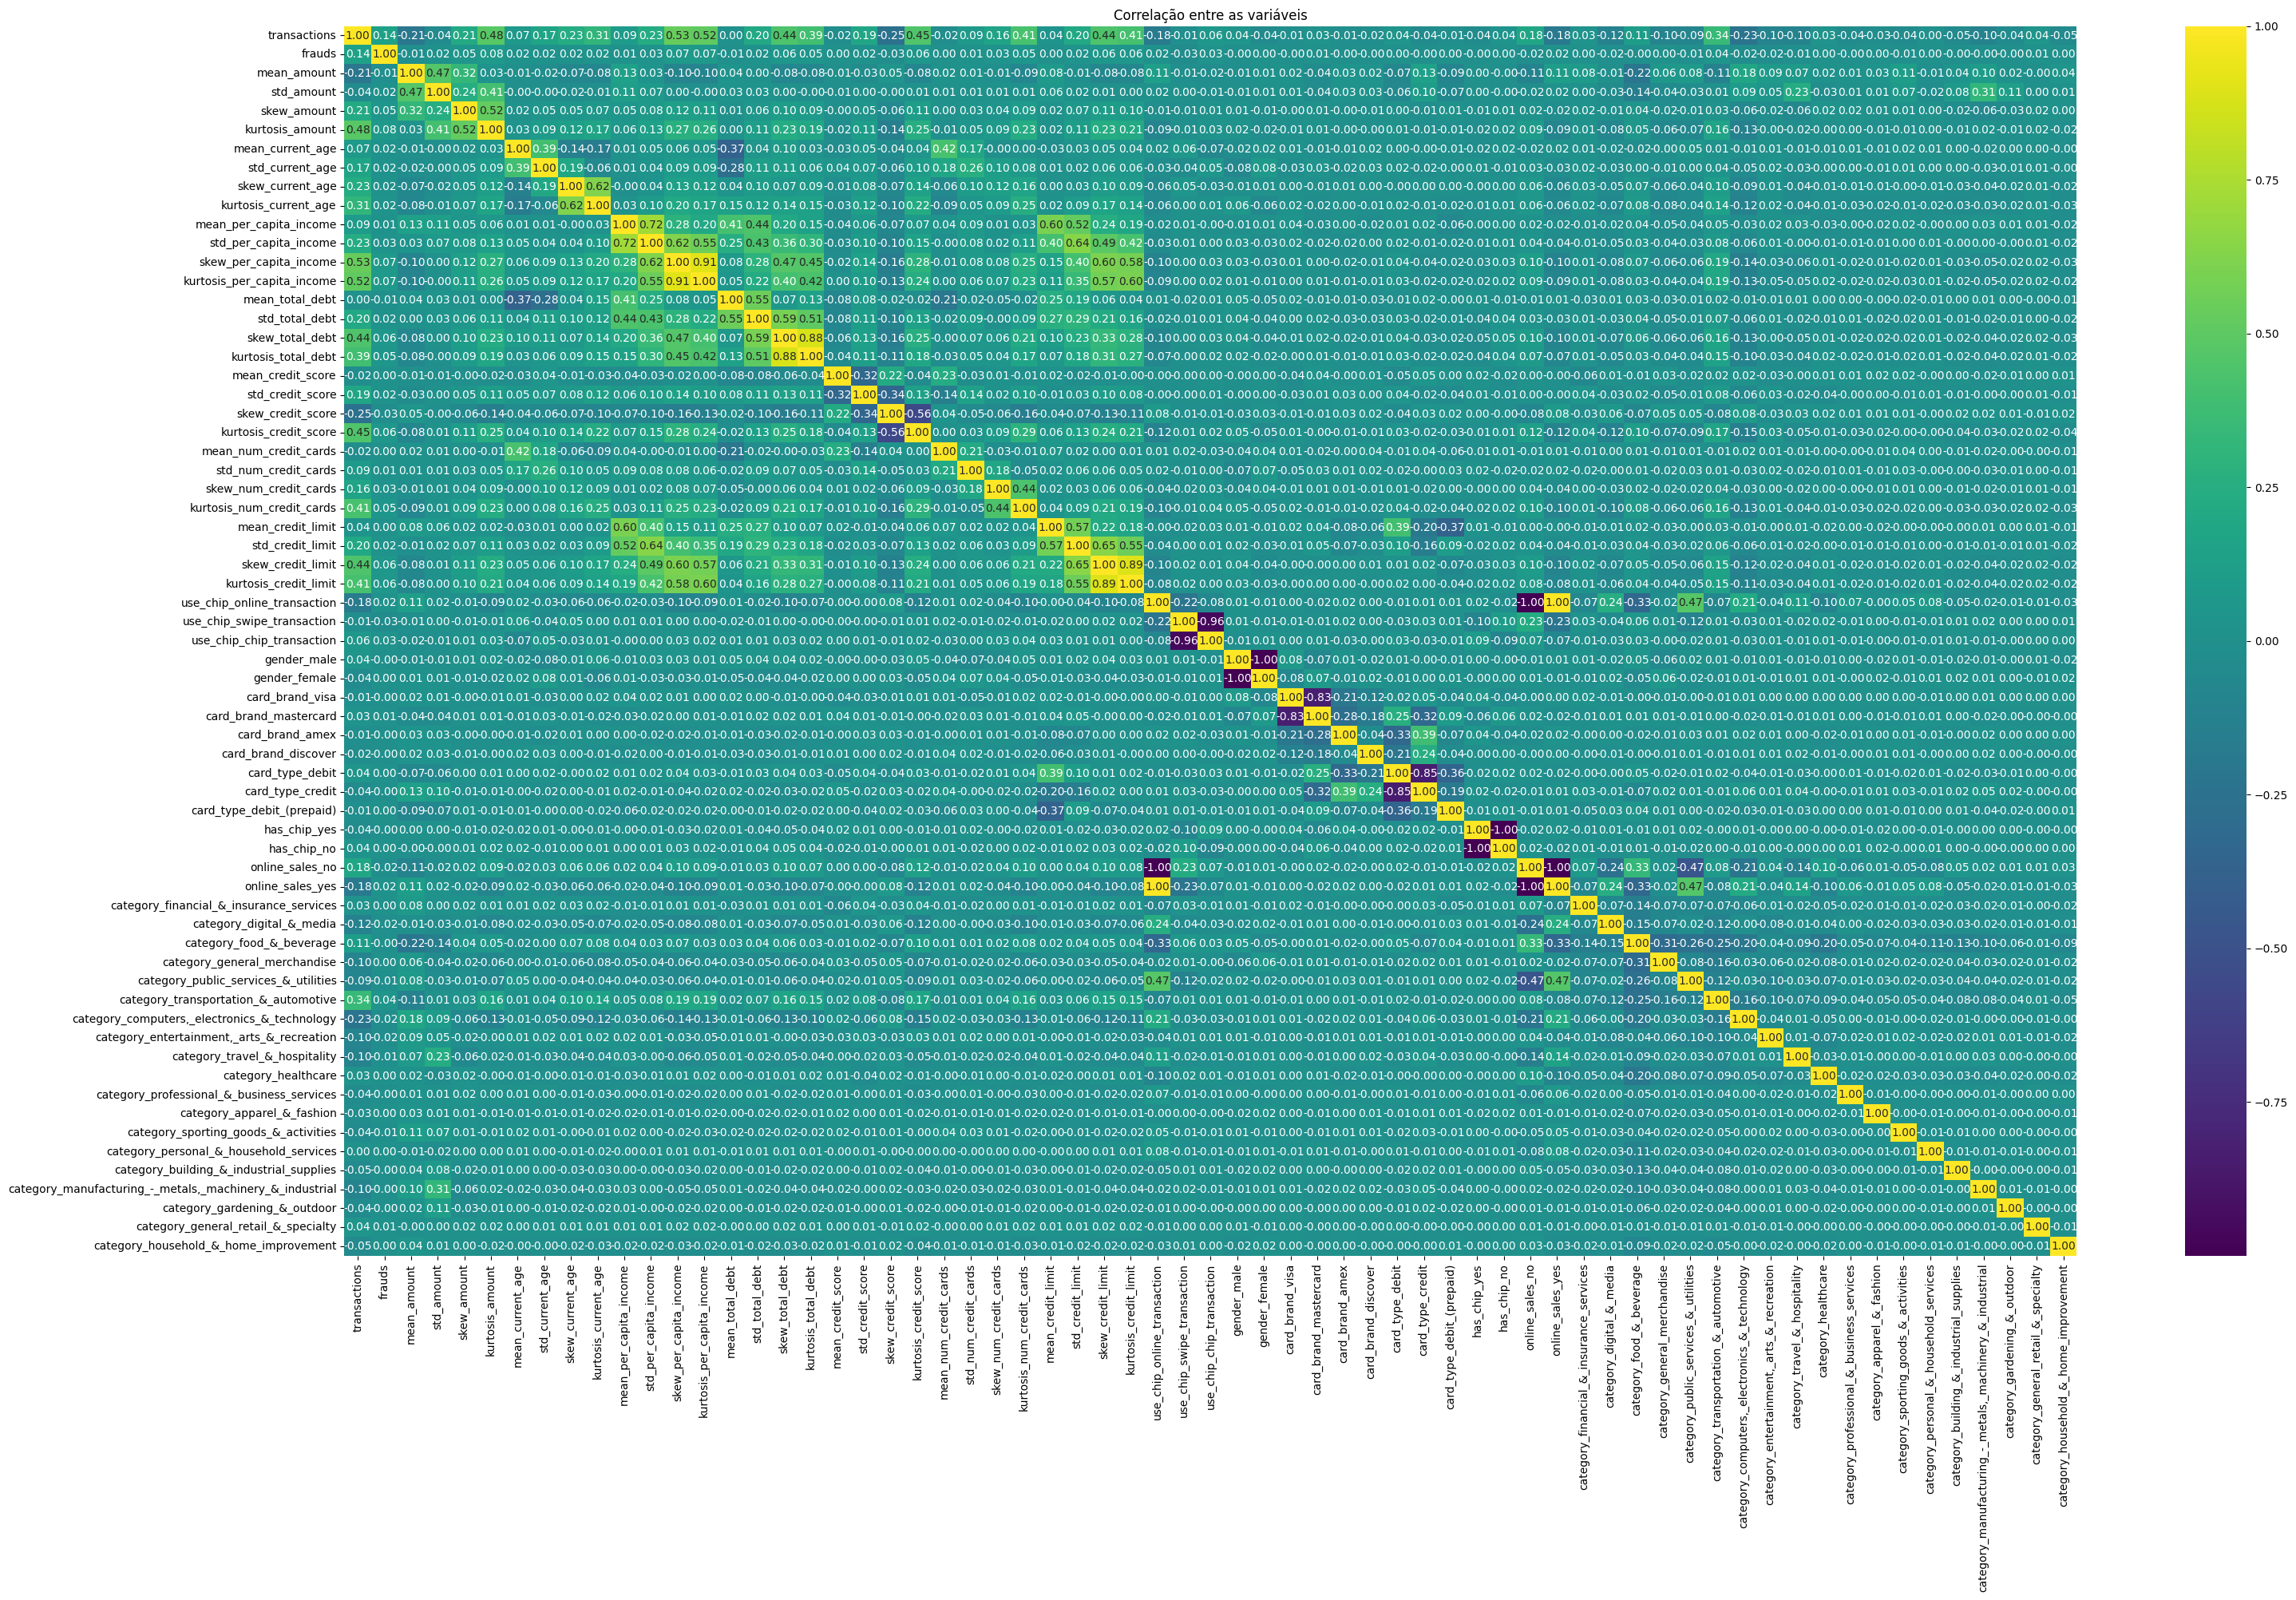

In [220]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()

plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()